# Reproducing Cardoso and Maselli's results

Cardoso, V., & Maselli, A. (2020). Constraints on the astrophysical environment of binaries with gravitational-wave observations. Astronomy and Astrophysics, 644(2019), 1–6. https://doi.org/10.1051/0004-6361/202037654

## Getting vacuum waveforms from `PyCBC` and LISA noise strain from `gwent`

In this notebook, we use `IMRPhenomHM` (and subsequently, `TaylorF2`) as waveform templates from which we will obtain *modified* waveforms due to the presence of astrophysical environments.

In [ ]:
# load pycbc and waveform plugin for modifying the waveforms
import sys
!{sys.executable} -m pip install pycbc ligo-common lalsuite --no-cache-dir
!{sys.executable} -m pip install git+https://github.com/gwastro/example-waveform-plugin
!{sys.executable} -m pip install gwent gwinc --no-cache-dir

#preliminaries
import pycbc
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.constants import golden_ratio
from scipy.interpolate import interp1d

import astropy.constants as const
import astropy.units as u

import gwent
import gwent.detector as detector
import gwent.binary as binary

#Turn off warnings for tutorial
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('seaborn-paper')


     |████████████████████████████████| 6.3MB 11.4MB/s 
     |████████████████████████████████| 27.3MB 1.4MB/s 
     |████████████████████████████████| 61kB 29.6MB/s 
     |████████████████████████████████| 1.6MB 37.8MB/s 
     |████████████████████████████████| 890kB 46.4MB/s 
     |████████████████████████████████| 81kB 56.8MB/s 
     |████████████████████████████████| 61kB 44.6MB/s 
     |████████████████████████████████| 3.2MB 50.0MB/s 
  Created wheel for ligo-segments: filename=ligo_segments-1.3.0-cp37-cp37m-linux_x86_64.whl size=86000 sha256=a24c781de95944b91ec6e2e0830d842382261bed2fe0be3256bc348b6b38feb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcyglna_/wheels/21/e8/4d/bfb61e2ececd2ba80c3b5c6691a8434358a655d6c2e7730ca9
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp37-cp37m-linux_x86_64.whl size=416789 sha256=e9d5626c4dd6032895fde526062961bfd7c549037c48a7e09f4de43c687b8421
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcyglna_/wheels/aa/fa/38/d61b0

In [ ]:
# gwent preliminaries for executing LISA detector noise strain

L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr
f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

LISA_prop1 = detector.SpaceBased('LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)

LISA_prop1_Snf = (LISA_prop1.h_n_f.value)**2/(LISA_prop1.fT.value) #convert h_n(f) to S_n(f), consult Moore et. al 2015, CQG 015014

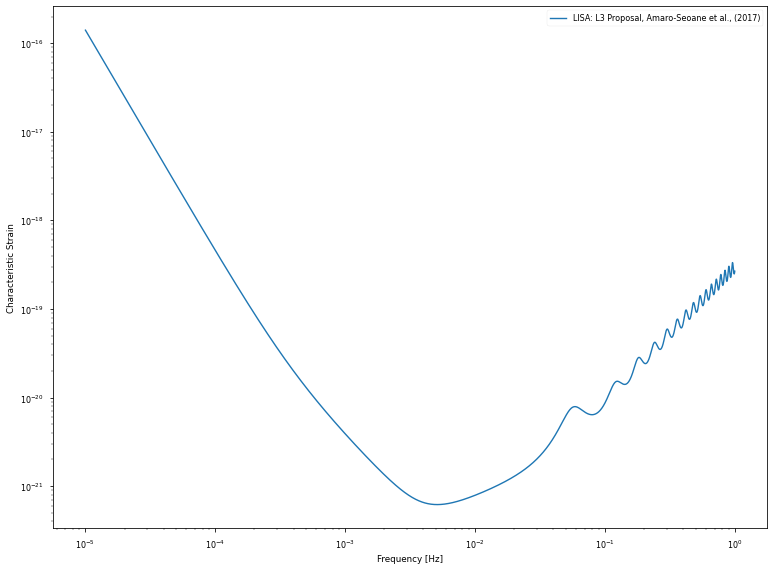

In [ ]:
plt.figure(figsize=(12.8,9.6))
plt.loglog(LISA_prop1.fT,LISA_prop1.h_n_f,label=r'LISA: L3 Proposal, Amaro-Seoane et al., (2017)')
#plt.loglog(LISA_prop1_w_background.fT,LISA_prop1_w_background.h_n_f,label=r'LISA: L3 Proposal + Background',
#           linestyle='--')
#plt.loglog(LISA_prop2.fT,LISA_prop2.h_n_f,label=r'Robson et al., (2019)',zorder=-1)
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Characteristic Strain')
plt.tick_params(axis = 'both',which = 'major')
plt.legend()

In [ ]:
# Constants

G = 6.67e-11 # Newton's Gravitational Constant, in m^3/kg/s^2
c = 2.99e8 # speed of light in m/s

D_L = 1e3 # 1 Gpc in terms of Mpc
m1 = 1e5 # primary mass in M_sun
m2 = 10 # secondary mass in M_sun
chi1 = 0.8 # primary dimensionless spin (c/G s/m_1^2)
chi2 = 0.5 # secondary dimensionless spin (c/G s/m_2^2)
f_delta = 1e-6 # The frequency step used to generate the waveform (in Hz).
f_lower = 1e-5 # The starting frequency of the waveform (in Hz).
approx = str('IMRPhenomB') # GW approximant to be used
M = m1 + m2 # total mass (in source frame)
mu = (m1*m2)/M # reduced mass of the system
eta = mu/M # symmetric mass ratio
m_chirp = M*(eta**(3/5)) # chirp mass
tau_c = (5/256*eta)*(G*M/c**3)*(np.pi*G*M*f_lower/c**3)**(-8/3) # time at coalescence in terms of initial GW frequency in [s], eq. 3.178c of Creighton
# phi_c = 0.0 # phase at coalescence (default)
chi_eff = (m1*chi1 + m2*chi2)/M # effective spin

# all that follows are for beta=0

gamma_grav = 2.0 # gamma for gravitational pull
gamma_drag = 11.0/3.0 # gamma for gravitational drag
gamma_bondi = 11.0/3.0 # gamma for Bondi accretion
gamma_colless = 3.0 # gamma for collisionless accretion

kappa_grav = 1.0 # kappa for gravitational pull
kappa_drag = -eta**(-3)*(1-3*eta)*(np.pi**(-11/3)) # kappa for gravitational drag
kappa_bondi = -eta**(-3)*(1-3*eta)*(np.pi**(-11/3)) # kappa for Bondi accretion
kappa_colless = -eta**(-1)*(np.pi**(-3)) # kappa for collisionless accretion

In [ ]:
print(m_chirp)
print(eta)

398.09920888777987
9.998000299960005e-05


Recall from Cardoso & Maselli (2021),

\begin{equation}\tag{12}
\delta_{\Psi_{\text{env}}} = \kappa_\beta M^{2-\beta} R^{\beta} \rho_0 (Mf)^{-\gamma}.
\end{equation}

For our purposes, $\beta =0$; "in this case the most constraining effect is given by the gravitational drag". Then $\Psi_{\text{env}} = \Psi_{\text{GR}} \delta_{\Psi_{\text{env}}}$.

In [ ]:
# functions

def return_psi_0_GR(f):
  return (3/128)*(m_chirp*np.pi*f)**(-5/3)

def return_psi_env_grav(f, rho_0=1): # rho_0 is normalized to density of water
  delta_env_grav = kappa_grav*M**2*rho_0*(M*f)**(-gamma_grav)
  return return_psi_0_GR(f)*delta_env_grav

def return_psi_env_drag(f, rho_0=1): # rho_0 is normalized to density of water
  delta_env_drag = kappa_drag*M**2*rho_0*(M*f)**(-gamma_drag)
  return return_psi_0_GR(f)*delta_env_drag

def return_psi_env_bondi(f, rho_0=1): # rho_0 is normalized to density of water
  delta_env_bondi = kappa_bondi*M**2*rho_0*(M*f)**(-gamma_bondi)
  return return_psi_0_GR(f)*delta_env_bondi

def return_psi_env_colless(f, rho_0=1): # rho_0 is normalized to density of water
  delta_env_colless = kappa_colless*M**2*rho_0*(M*f)**(-gamma_colless)
  return return_psi_0_GR(f)*delta_env_colless

In [ ]:
# Get a vacuum frequency domain waveform
from pycbc import waveform

hptilde, hctilde = waveform.get_fd_waveform(approximant=approx,
                             mass1=m1, mass2=m2, distance = D_L, delta_f=f_delta, f_lower=f_lower)

Cell for interpolating the vacuum waveform to the LISA frequencies (and converting it to a `numpy` array). Double-check for mistakes in the process.

In [ ]:
return_hptilde_interp = interp1d(hptilde.sample_frequencies, hptilde, fill_value="extrapolate")

#hptilde.resize(len(LISA_prop1.fT))
hptilde_LISA = return_hptilde_interp(LISA_prop1.fT.value)

In [ ]:
print(hptilde.sample_frequencies.max()) # frequency at coalescence??? NO, but the GW frequency at ISCO, from Borhanian (2020) GWBENCH paper
print(np.amax(LISA_prop1.fT.value)) # LISA noise density maximum frequency

0.262144
0.9983890809889848


(0.0, 0.0001)

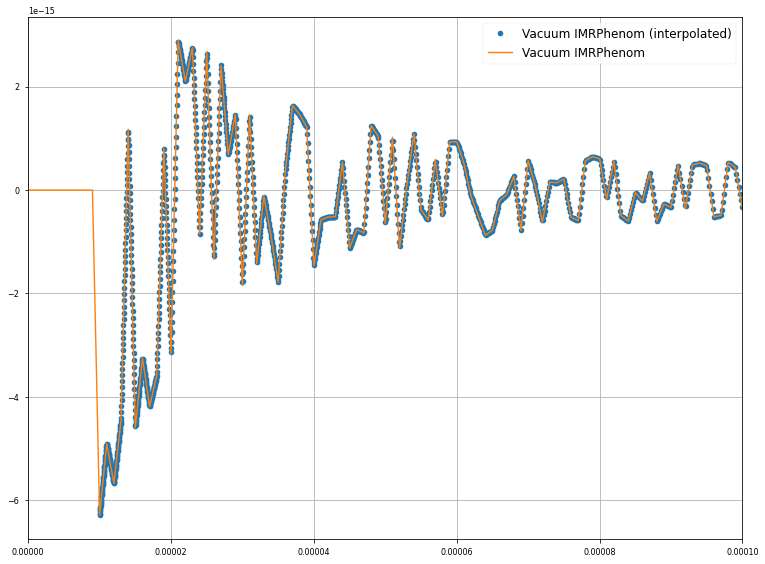

In [ ]:
plt.figure(0, figsize=(12.8,9.6))
plt.plot(LISA_prop1.fT.value, hptilde_LISA.real, 'o', label='Vacuum IMRPhenom (interpolated)')
plt.plot(hptilde.sample_frequencies, hptilde.real(), label='Vacuum IMRPhenom')
plt.legend(fontsize='large')
plt.grid()
plt.xlim(0,0.0001)
#plt.ylim(-1e-14,1e-14)

## Apply environmental effects by multiplying the FD waveform with $\exp(i\Psi_{\text{env}})$, where $\Psi_{\text{env}} = \Psi_{\text{GR}} \delta_{\Psi_{\text{env}}}$ (aka dephasing).

In this cell, we create the added phase of each environmental effect by using `list(map())` to evaluate our user-defined functions against the iterable `hptilde.sample_frequencies`. We also set $\rho_0/\rho_{\text{H2O}} = 0.1$ in this setup. We then multiply the waveform `htilde` (which is assumed to have the form $\tilde{h}(f) = \mathcal{A}\exp(i\Psi_{\text{GR}})$) with $\exp(i\Psi_{\text{env}})$ to obtain the modified waveform $\tilde{h}_{\text{env}}(f)$.

**Warning:** this modified waveform array may have complex elements.

In [ ]:
def return_hp_grav_fd(rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_grav(LISA_prop1.fT.value, rho_0)))

def return_hp_drag_fd(rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_drag(LISA_prop1.fT.value, rho_0)))

def return_hp_bondi_fd(rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_bondi(LISA_prop1.fT.value, rho_0)))

def return_hp_colless_fd(rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_colless(LISA_prop1.fT.value, rho_0)))

In [ ]:
print(hptilde_LISA.imag[hptilde_LISA.imag != 0])
print(hp_grav_fd.imag[hp_grav_fd.imag !=0])

[-4.62265334e-15 -4.62821043e-15 -4.63377649e-15 ... -1.26983861e-20
  7.90773987e-21  1.47642945e-20]
[-2.68439436e-15  7.90250963e-16  7.49390072e-15 ... -1.26978833e-20
  7.90844157e-21  1.47640002e-20]


First check: Comparing the effectiveness of directly evaluating the functions `return_hp_(env)_fd` with the frequency array of the LISA noise strain AND using `list(map())` to evaluate the user-defined functions `return_psi_env` to create the array for $\Psi_{\text{env}}$.

In [ ]:
# Apply environmental effects

import itertools

# First, create array for exp(i\Psi_env)

psi_env_grav = list(map(return_psi_env_grav, LISA_prop1.fT.value, itertools.repeat(1.0, len(LISA_prop1.fT))))
psi_env_drag = list(map(return_psi_env_drag, LISA_prop1.fT.value, itertools.repeat(1.0, len(LISA_prop1.fT))))
psi_env_bondi = list(map(return_psi_env_bondi, LISA_prop1.fT.value, itertools.repeat(1.0, len(LISA_prop1.fT))))
psi_env_colless = list(map(return_psi_env_colless, LISA_prop1.fT.value, itertools.repeat(1.0, len(LISA_prop1.fT))))

psi_env_grav = np.array(psi_env_grav)
psi_env_drag = np.array(psi_env_drag)
psi_env_bondi = np.array(psi_env_bondi)
psi_env_colless = np.array(psi_env_colless)

hp_grav_fd_old = np.multiply(hptilde_LISA,np.exp(1.0j*psi_env_grav))
hp_drag_fd_old = np.multiply(hptilde_LISA,np.exp(1.0j*psi_env_drag))
hp_bondi_fd_old = np.multiply(hptilde_LISA,np.exp(1.0j*psi_env_bondi))
hp_colless_fd_old = np.multiply(hptilde_LISA,np.exp(1.0j*psi_env_colless))

In [ ]:
hp_grav_fd = return_hp_grav_fd()
hp_drag_fd = return_hp_drag_fd()
hp_bondi_fd = return_hp_bondi_fd()
hp_colless_fd = return_hp_colless_fd()

In [ ]:
print(hp_grav_fd)
print(hp_grav_fd_old)

[-7.32066545e-15-2.68439436e-15j  7.74246889e-15+7.90250963e-16j
 -2.04564593e-15+7.49390072e-15j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
[-7.32066545e-15-2.68439436e-15j  7.74246889e-15+7.90250963e-16j
 -2.04564593e-15+7.49390072e-15j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


(1e-05, 1.5e-05)

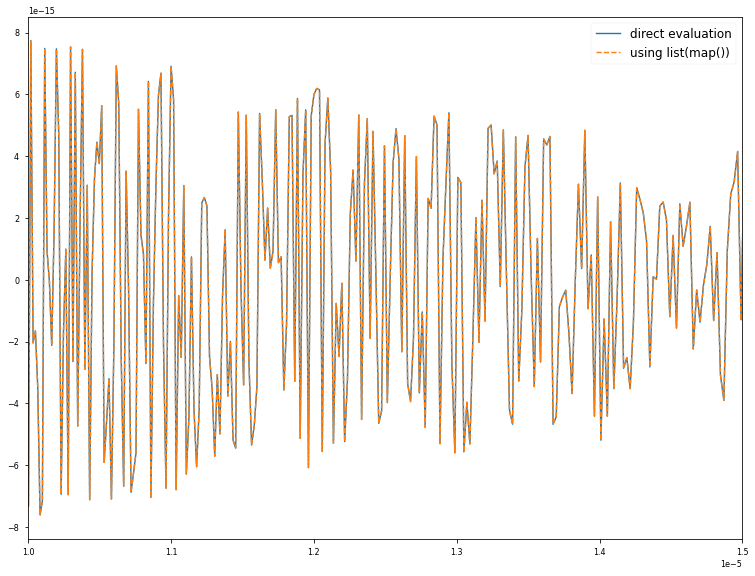

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(LISA_prop1.fT.value, hp_grav_fd.real, '-', label='direct evaluation')
plt.plot(LISA_prop1.fT.value, hp_grav_fd_old.real, '--', label='using list(map())')
plt.legend(loc='best', fontsize='large')
plt.xlim(0.00001,0.000015)

In [ ]:
Sp_grav_fd = 4*LISA_prop1.fT.value*abs(hp_grav_fd)
Sp_drag_fd = 4*LISA_prop1.fT.value*abs(hp_drag_fd)
Sp_bondi_fd = 4*LISA_prop1.fT.value*abs(hp_bondi_fd)
Sp_colless_fd = 4*LISA_prop1.fT.value*abs(hp_colless_fd)

print(Sp_grav_fd.shape)

(7142,)


In [ ]:
plt.figure(1, figsize=(12.8,9.6))
#plt.loglog(LISA_prop1.fT.value, hptilde.real, label='Vacuum IMRPhenom')
plt.loglog(LISA_prop1.fT.value, LISA_prop1_Snf, '-', label=r'LISA $S_n(f)$', linewidth=2.0)
plt.loglog(LISA_prop1.fT.value, Sp_grav_fd.real, 'o', label='IMRPhenomB + gravitational pull')
plt.loglog(LISA_prop1.fT.value, Sp_drag_fd.real, '^', label='IMRPhenomB + gravitational drag')
plt.loglog(LISA_prop1.fT.value, Sp_bondi_fd.real, '.', label='IMRPhenomB + Bondi accretion', alpha=0.3)
plt.loglog(LISA_prop1.fT.value, Sp_colless_fd.real, 's', label='IMRPhenomB + collisionless accretion', alpha=0.3)
plt.legend(fontsize='large', loc='best')
#plt.grid()
plt.title(r'Modified FD waveforms for $\rho_0/\rho_{H_2O} = 0.1$', fontsize='large')
plt.xlabel('Frequency [Hz]', fontsize='large')
plt.ylabel(r'$S_h(f)$', fontsize='large')
#plt.xlim(0.00001,0.0001)

In [ ]:
def get_overlap(noise, h1, h2, fI, fE, f):
  def integrand(f, noise, h1, h2):
    return np.multiply(h1(f),np.conjugate(h2(f)))/noise
  scipy.integrate.quad(integrand, fI, fE)

## Evaluating $\Gamma_{\rho_0 \rho_0}$ analytically

Here, we want to evaluate $\dfrac{\partial \tilde{h}}{\partial \rho_0}$ which will be used in evaluating the Fisher matrix element $\Gamma_{\rho_0 \rho_0} = \int_{f_{\text{min}}}^{f_{\text{max}}} \dfrac{1}{S_n(f)} \Bigg(\dfrac{\partial \tilde{h}}{\partial \rho_0}\Bigg)^2 ~df$.

Recall $\tilde{h}_{\text{env}}(f) = \tilde{h}(f) \exp(i\Psi_{\text{env}})$, where $\tilde{h}(f)$ is not a function of $\rho_0$. Then,

\begin{equation}
\dfrac{\partial \tilde{h}}{\partial \rho_0} = \tilde{h}(f) \dfrac{\partial}{\partial \rho_0} \exp(i\Psi_{\text{env}}) = \tilde{h}(f) \dfrac{\partial}{\partial \rho_0} \exp\Big(i \Psi_{\text{GR}} \kappa_0 M^2 (Mf)^{-\gamma_0} \rho_0\Big) 
\end{equation}

\begin{equation}
= \tilde{h}(f) \Big(i \Psi_{\text{GR}} \kappa_0 M^2 (Mf)^{-\gamma_0}\Big) \exp\Big(i \Psi_{\text{GR}} \kappa_0 M^2 (Mf)^{-\gamma_0} \rho_0\Big) = \Big(i \Psi_{\text{GR}} \kappa_0 M^2 (Mf)^{-\gamma_0} \Big) \tilde{h}_{\text{env}}(f)
\end{equation}

So we only need to multiply $\tilde{h}_{\text{env}}(f)$ with $\Big(i \Psi_{\text{GR}} \kappa_0 M^2 (Mf)^{-\gamma_0}\Big)$ _(which is a very large factor, given $M$)_.

Insert this function of $f$ onto

\begin{equation}
\Gamma_{\rho_0 \rho_0} = \int_{10^{-5}}^1 \dfrac{1}{S_n(f)} \Bigg(\dfrac{\partial \tilde{h}_{\text{env}}}{\partial \rho_0}\Bigg)^2 ~df
\end{equation}

Invert the whole Fisher matrix to get the covariance matrix then get $\sigma_{\rho_0} = \sqrt{\Sigma_{\rho_0 \rho_0}}$.

In [ ]:
mult_grav = np.array(1.0j*return_psi_0_GR(LISA_prop1.fT.value)*kappa_grav*M**2*(M*LISA_prop1.fT.value)**(-gamma_grav))
mult_drag = np.array(1.0j*return_psi_0_GR(LISA_prop1.fT.value)*kappa_drag*M**2*(M*LISA_prop1.fT.value)**(-gamma_drag))
mult_bondi = np.array(1.0j*return_psi_0_GR(LISA_prop1.fT.value)*kappa_bondi*M**2*(M*LISA_prop1.fT.value)**(-gamma_bondi))
mult_colless = np.array(1.0j*return_psi_0_GR(LISA_prop1.fT.value)*kappa_colless*M**2*(M*LISA_prop1.fT.value)**(-gamma_colless))

ddrho_grav_fd = np.multiply(hp_grav_fd, mult_grav)
ddrho_drag_fd = np.multiply(hp_drag_fd, mult_drag)
ddrho_bondi_fd = np.multiply(hp_bondi_fd, mult_bondi)
ddrho_colless_fd = np.multiply(hp_colless_fd, mult_colless)

In [ ]:
0.2/(1*10**(-16))

2000000000000000.2

In [ ]:
print(kappa_grav*M**2)

10002000100.0


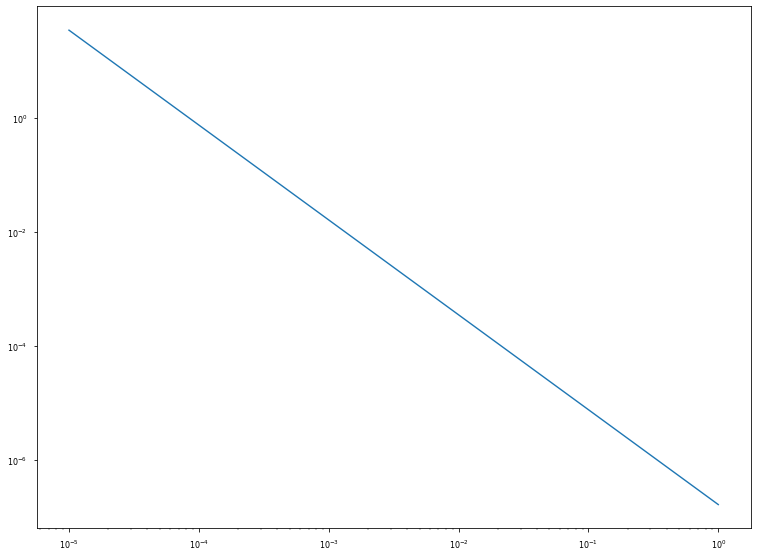

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.loglog(LISA_prop1.fT.value, return_psi_0_GR(LISA_prop1.fT.value))
#plt.xlim(0,0.0001)

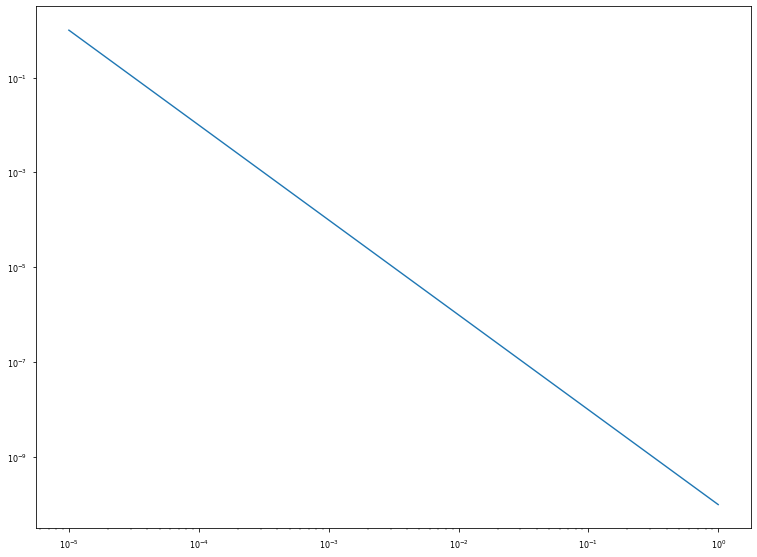

In [ ]:
plt.figure(figsize=(12.8,9.6))
plt.loglog(LISA_prop1.fT.value, (M*LISA_prop1.fT.value)**(-gamma_grav))

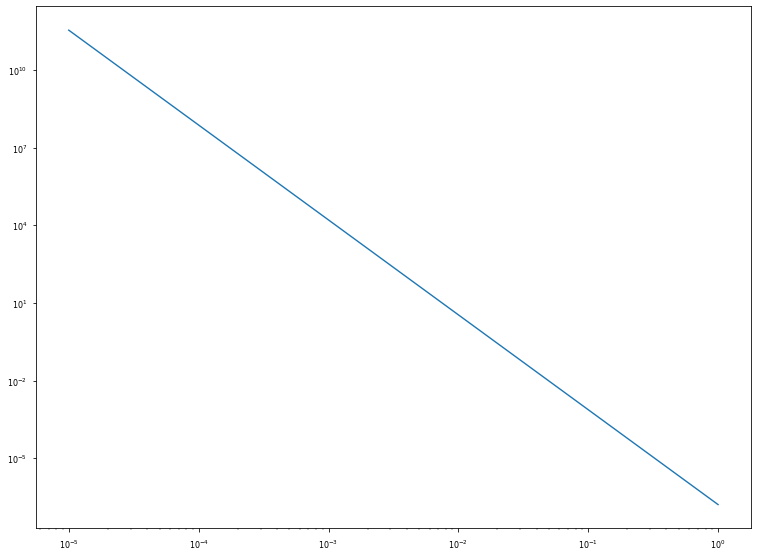

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.loglog(LISA_prop1.fT.value, return_psi_0_GR(LISA_prop1.fT.value)*kappa_grav*M**2*(M*LISA_prop1.fT.value)**(-gamma_grav))
#plt.xticks()
plt.minorticks_on()

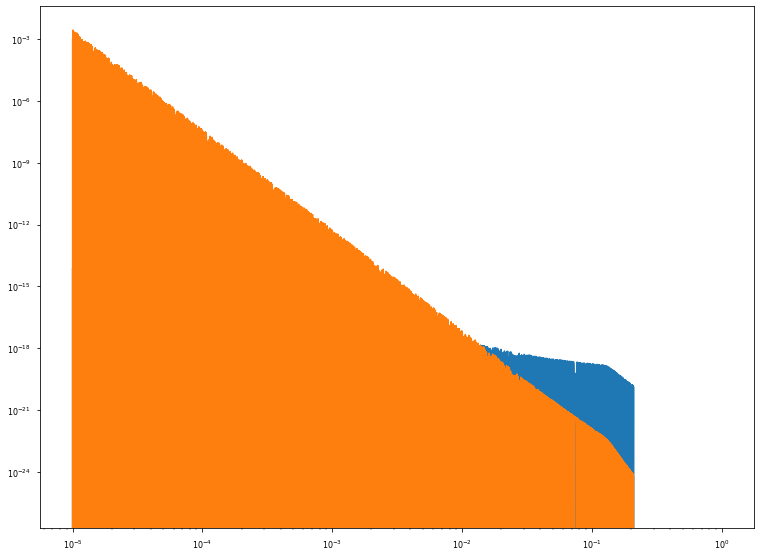

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.loglog(LISA_prop1.fT.value, hp_grav_fd)
plt.loglog(LISA_prop1.fT.value, ddrho_grav_fd)
#plt.loglog(LISA_prop1.fT.value, hptilde_LISA)

In [ ]:
print(abs(hptilde_LISA).min())

0.0


(0.0, 0.0001)

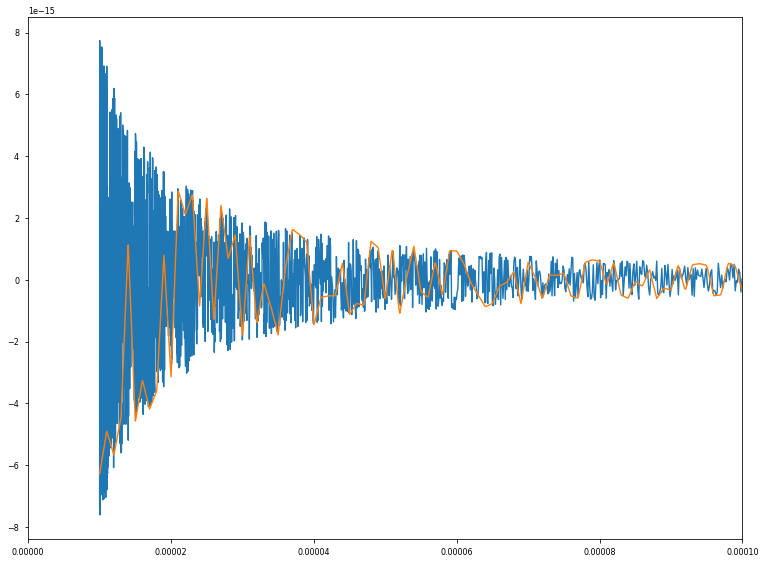

In [ ]:
plt.figure(figsize=(12.8,9.6))
#plt.plot(hptilde.sample_frequencies, hptilde)
plt.plot(LISA_prop1.fT.value, hp_grav_fd)
plt.plot(LISA_prop1.fT.value, hptilde_LISA)
plt.xlim(0,0.0001)

In [ ]:
print(hptilde[0:10].real)

<bound method Array.real of <pycbc.types.frequencyseries.FrequencySeries object at 0x7fb9a4de6090>>


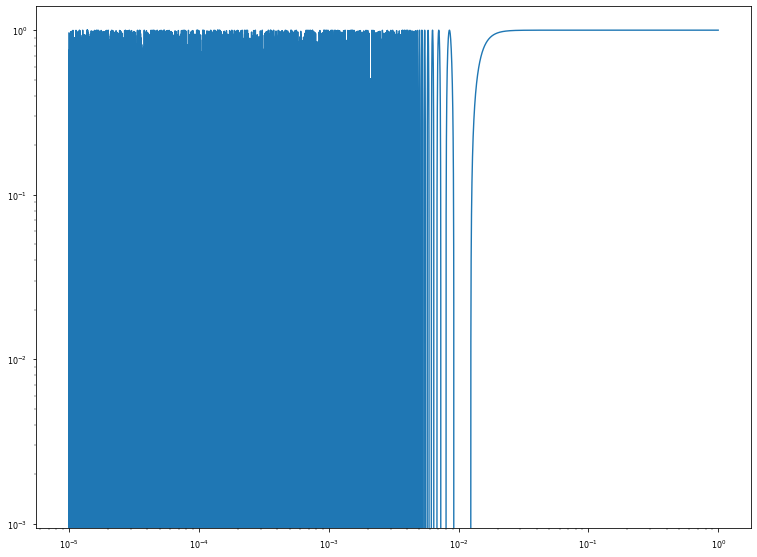

In [ ]:
plt.figure(figsize=(12.8, 9.6))


In [ ]:
#print(mult_grav)
print(gamma_colless)
print(return_psi_0_GR(LISA_prop1.fT.value))

3.0
[3.47677139e+01 3.46744317e+01 3.45813998e+01 ... 1.62745817e-07
 1.62309168e-07 1.61873691e-07]


(1e-05, 5e-05)

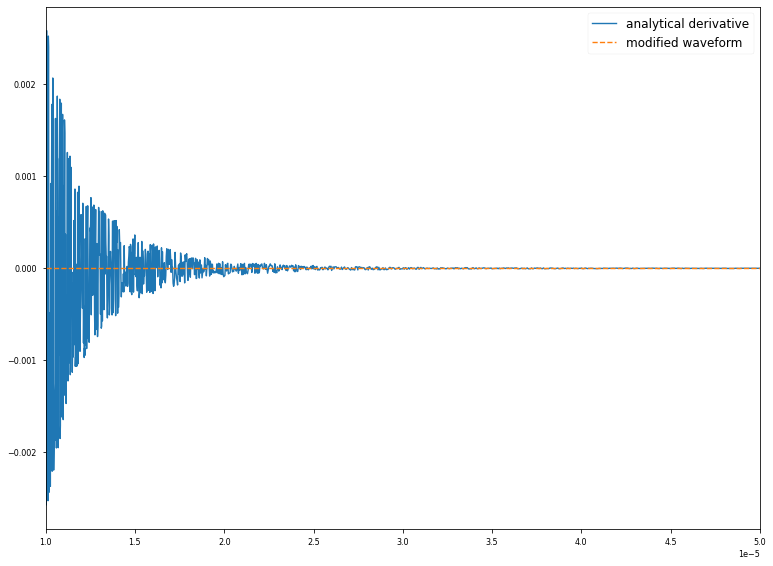

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(LISA_prop1.fT.value, ddrho_grav_fd, '-', label='analytical derivative')
plt.plot(LISA_prop1.fT.value, hp_grav_fd, '--', label='modified waveform')
plt.legend(fontsize='large')
plt.xlim(0.00001, 0.00005)

In [ ]:
integrand_grav = np.multiply(np.abs(ddrho_grav_fd), np.abs(ddrho_grav_fd))/LISA_prop1_Snf
integrand_drag = np.multiply(np.abs(ddrho_drag_fd), np.abs(ddrho_drag_fd))/LISA_prop1_Snf
integrand_bondi = np.multiply(np.abs(ddrho_bondi_fd), np.abs(ddrho_bondi_fd))/LISA_prop1_Snf
integrand_colless = np.multiply(np.abs(ddrho_colless_fd), np.abs(ddrho_colless_fd))/LISA_prop1_Snf

Fisher_rho0rho0_grav = np.sum(integrand_grav)
Fisher_rho0rho0_drag = np.sum(integrand_drag)
Fisher_rho0rho0_bondi = np.sum(integrand_bondi)
Fisher_rho0rho0_colless = np.sum(integrand_colless)

print(Fisher_rho0rho0_grav) # sigma_grav = 10^-4
print(Fisher_rho0rho0_drag) # sigma_grav = 10^-19
print(Fisher_rho0rho0_bondi)
print(Fisher_rho0rho0_colless) # sigma_grav = 10^-10

5.2497040165506003e+23
6.644727997383804e+43
6.644727997383804e+43
3.695158243562381e+28


## Numerical Differentiation

Here, we want to implement numerical differentiation and test it on $\Gamma_{\rho_0 \rho_0}$ before attempting to differentiate the numerical waveform `IMRPhenom`.

Recall the central difference formula for some $f(x,y,z)$

\begin{equation}
  \dfrac{\partial f}{\partial x}\Bigg\rvert_{x=a} \approx \dfrac{f(a+h,y,z) - f(a-h,y,z)}{2h}
\end{equation}

Then, for some $a \in (0,1)\rho_{\text{H2O}}$ and $h=0.01$,

\begin{equation}
  \dfrac{\partial \tilde{h}}{\partial \rho_0}\Bigg\rvert_{\rho_0=a} \approx \dfrac{\tilde{h}(a+h,\ln \mathcal{M},\ln \eta, \tau_c, \phi_c, \chi_{\text{eff}}) - \tilde{h}(a-h,\ln \mathcal{M},\ln \eta, \tau_c, \phi_c, \chi_{\text{eff}})}{2h}
\end{equation}

where the other variables remain constant as we perform differentiation.

Steps:

1. Obtain $\tilde{h}_{\text{env}}$ as a user-defined function of $\rho_0, \ln \mathcal{M},\ln \eta, \tau_c, \phi_c, \chi_{\text{eff}}$. This function should return the modified waveform as a function of the specified variables. _Problem: How do you extract $\ln \mathcal{M},\ln \eta, \tau_c, \phi_c, \chi_{\text{eff}}$ from the vacuum waveform, if the waveform is inherently numerical?_

2. Apply the `derivative` function to this user-defined function. Separate the user-defined functions according to the astrophysical environmental effect.

3. Return either (a) an array along the differentiated variable, e.g. $\dfrac{\partial \tilde{h}}{\partial \rho_0} \Bigg\rvert_{\rho_0 \in [0,1]}$ or (b) a single float, e.g. $\dfrac{\partial \tilde{h}}{\partial \rho_0} \Bigg\rvert_{\rho_0= 0.1}$

In [ ]:
def get_partial(waveform, a, h=0.01):
  return (waveform(a+h) - waveform(a-h))/2*h

num_ddrho_hp_grav_array = get_partial(return_hp_grav_fd, 1.0)
num_ddrho_hp_drag_array = get_partial(return_hp_drag_fd, 1.0)
num_ddrho_hp_bondi_array = get_partial(return_hp_bondi_fd, 1.0)
num_ddrho_hp_colless_array = get_partial(return_hp_colless_fd, 1.0)

print(num_ddrho_hp_grav_array[-5:-1])

[0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [ ]:
plt.figure(figsize=(12.8,9.6))
plt.plot(LISA_prop1_Snf, num_ddrho_hp_grav_array, 'o', label='numerical derivative (Marco)')
plt.plot(LISA_prop1_Snf, hp_grav_fd, label=r'$\tilde{h}_+(f)$')
#plt.plot(LISA_prop1_Snf, result_grav, label='numerical derivative', alpha=0.5)
plt.legend(fontsize='large')
plt.grid()
#plt.xlim(0, 0.0001)

In [ ]:
num_integrand_grav = np.multiply(np.abs(num_ddrho_hp_grav_array), np.abs(num_ddrho_hp_grav_array))/LISA_prop1_Snf
num_integrand_drag = np.multiply(np.abs(num_ddrho_hp_drag_array), np.abs(num_ddrho_hp_drag_array))/LISA_prop1_Snf
num_integrand_bondi = np.multiply(np.abs(num_ddrho_hp_bondi_array), np.abs(num_ddrho_hp_bondi_array))/LISA_prop1_Snf
num_integrand_colless = np.multiply(np.abs(num_ddrho_hp_colless_array), np.abs(num_ddrho_hp_colless_array))/LISA_prop1_Snf

num_Fisher_rho0rho0_grav = np.sum(num_integrand_grav)
num_Fisher_rho0rho0_drag = np.sum(num_integrand_drag)
num_Fisher_rho0rho0_bondi = np.sum(num_integrand_bondi)
num_Fisher_rho0rho0_colless = np.sum(num_integrand_colless)

print('analytical:', Fisher_rho0rho0_grav, ' numerical:', num_Fisher_rho0rho0_grav) # sigma_grav = 10^-4
print('analytical:', Fisher_rho0rho0_drag, ' numerical:', num_Fisher_rho0rho0_drag) # sigma_drag = 10^-19
print('analytical:', Fisher_rho0rho0_bondi, ' numerical:', num_Fisher_rho0rho0_bondi)
print('analytical:', Fisher_rho0rho0_colless, ' numerical:', num_Fisher_rho0rho0_colless) # sigma_colless = 10^-10

analytical: 5.2497040165506003e+23  numerical: 11973.398617293615
analytical: 6.644727997383804e+43  numerical: 14551.262558077564
analytical: 6.644727997383804e+43  numerical: 14551.262558077564
analytical: 3.695158243562381e+28  numerical: 10770.150679431932


In [ ]:
#def num_diff_grav(htilde_env,a,h=0.01):
#  '''Calculate the numerical derivative for the gravitational pull effect
#  with respect to some parameter. Returns an array defined on the LISA_prop1.fT
#  axis or a float, depending on the value of a.

#  Parameters
#  ----------
#  htilde_env : function
#      Modified waveform. Must be a function of the parameter we want to differentiate
#  a : array or float
#      point/s at which we evaluate the derivative of the modified waveform
#  param : string
#      Parameter to differentiate: 'rho', 'ln m_chirp', 'ln eta', 'tau_c', 'phi_c', 'chi_eff'
#  '''
#  return derivative(htilde_env,a,h)
#  elif param == 'ln m_chirp':
#      return derivative()
#  elif param == 'ln eta':
#      return (f(a) - f(a - h))/h
#  elif param == 'tau_c':
#      return (f(a + h) - f(a))/h
#  elif param == 'phi_c':
#      return (f(a) - f(a - h))/h
#  elif param == 'chi_eff':
#      return (f(a + h) - f(a))/h
#  else:
#      raise ValueError("Parameter must be one of the ff: 'rho', 'ln m_chirp', 'ln eta', 'tau_c', 'phi_c', 'chi_eff'.")

In [ ]:
#rho0_arr = np.linspace(0,1,100)
#def return_num_ddrho_grav(f):
#  return num_diff_grav(return_hp_grav_fd, a=0.1)

#num_ddrho_grav = list(map(return_num_ddrho_grav, LISA_prop1.fT.value))

#num_integrand_grav = np.multiply(np.abs(num_ddrho_grav), np.abs(num_ddrho_grav))/LISA_prop1_Snf
#num_Fisher_rhorho_grav = np.sum(num_integrand_grav)

#print(num_Fisher_rhorho_grav)

In [ ]:
def try_return_hp_grav_fd(f, rho_0=1):
  curve = return_hptilde_interp(f)
  return np.multiply(curve,np.exp(1.0j*return_psi_env_grav(f, rho_0)))

def try_return_hp_drag_fd(f, rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_drag(f, rho_0)))

def try_return_hp_bondi_fd(f, rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_bondi(f, rho_0)))

def try_return_hp_colless_fd(f, rho_0=1):
  return np.multiply(hptilde_LISA,np.exp(1.0j*return_psi_env_colless(f, rho_0)))

In [ ]:
print(try_return_hp_grav_fd(1e-5))

(1.7188232634732118e-15-7.607649133054855e-15j)


In [ ]:
# set fiducial rho0 and stepsize
rho00 = 1.0
h = 0.01 
# initialize array
result_grav = np.zeros(len(LISA_prop1.fT.value))
result_drag = np.zeros(len(LISA_prop1.fT.value))
result_bondi = np.zeros(len(LISA_prop1.fT.value))
result_colless = np.zeros(len(LISA_prop1.fT.value))

# loop over frequencies
for i in range(len(LISA_prop1.fT.value)):
  freq = LISA_prop1.fT.value[i]
  rho01 = rho00 + h # for central difference
  rho02 = rho00 - h
  waveform_grav_rho01 = try_return_hp_grav_fd(freq, rho01)
  waveform_grav_rho02 = try_return_hp_grav_fd(freq, rho02)
  result_grav[i] = (waveform_grav_rho01 - waveform_grav_rho02)/(2*h)

for j in range(len(LISA_prop1.fT.value)):
#  freq = LISA_prop1.fT.value[i]
#  rho01 = rho00 + h # for central difference
#  rho02 = rho00 - h
  waveform_drag_rho01 = try_return_hp_drag_fd(freq, rho01)
  waveform_drag_rho02 = try_return_hp_drag_fd(freq, rho02)
  result_drag[j] = (waveform_drag_rho01[j] - waveform_drag_rho02[j])/(2*h)

for k in range(len(LISA_prop1.fT.value)):
#  freq = LISA_prop1.fT.value[i]
#  rho01 = rho00 + h # for central difference
#  rho02 = rho00 - h
  waveform_bondi_rho01 = try_return_hp_bondi_fd(freq, rho01)
  waveform_bondi_rho02 = try_return_hp_bondi_fd(freq, rho02)
  result_bondi[k] = (waveform_bondi_rho01[k] - waveform_bondi_rho02[k])/(2*h)

for l in range(len(LISA_prop1.fT.value)):
#  freq = LISA_prop1.fT.value[i]
#  rho01 = rho00 + h # for central difference
#  rho02 = rho00 - h
  waveform_colless_rho01 = try_return_hp_colless_fd(freq, rho01)
  waveform_colless_rho02 = try_return_hp_colless_fd(freq, rho02)
  result_colless[l] = (waveform_colless_rho01[l] - waveform_colless_rho02[l])/(2*h)

print(result_grav[0], abs(ddrho_grav_fd[0]), abs(num_ddrho_hp_grav_array[0]))

1.4445137833790727e-13 0.002709701112356867 5.605309021552562e-11


In [ ]:
print(waveform_grav_rho01)

[-6.27926606e-15-4.62265437e-15j -6.25699446e-15-4.62821146e-15j
 -6.23468694e-15-4.63377751e-15j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


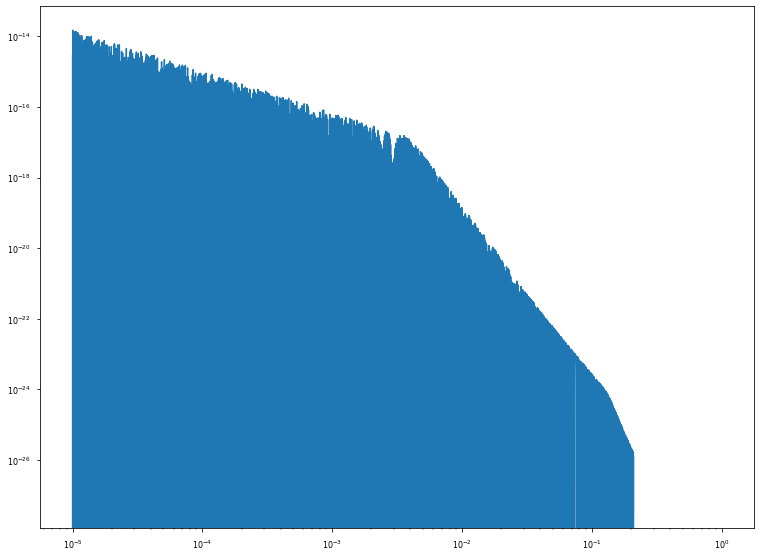

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.loglog(LISA_prop1.fT.value, try_return_hp_grav_fd(LISA_prop1.fT.value, rho01) - try_return_hp_grav_fd(LISA_prop1.fT.value, rho02), label='modified waveform')
#plt.plot(LISA_prop1.fT.value, result_grav, label='numerical derivative')

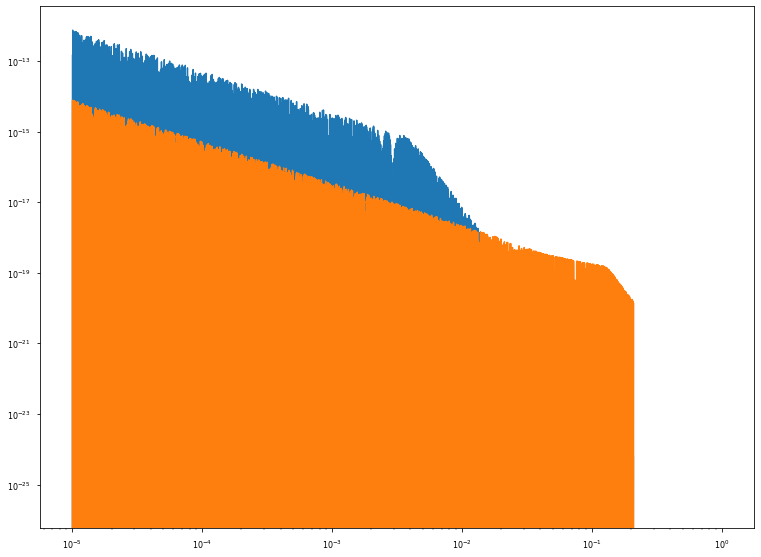

In [ ]:
plt.figure(figsize=(12.8,9.6))
plt.loglog(LISA_prop1.fT.value, result_grav)
#plt.loglog(LISA_prop1.fT.value, try_return_hp_grav_fd(LISA_prop1.fT.value, rho02))
plt.loglog(LISA_prop1.fT.value, hp_grav_fd)

In [ ]:
#print(hp_grav_fd[0])
print(result_grav[5000], abs(ddrho_grav_fd[5000]))

-1.590708735595226e-21 2.3378554302060325e-20


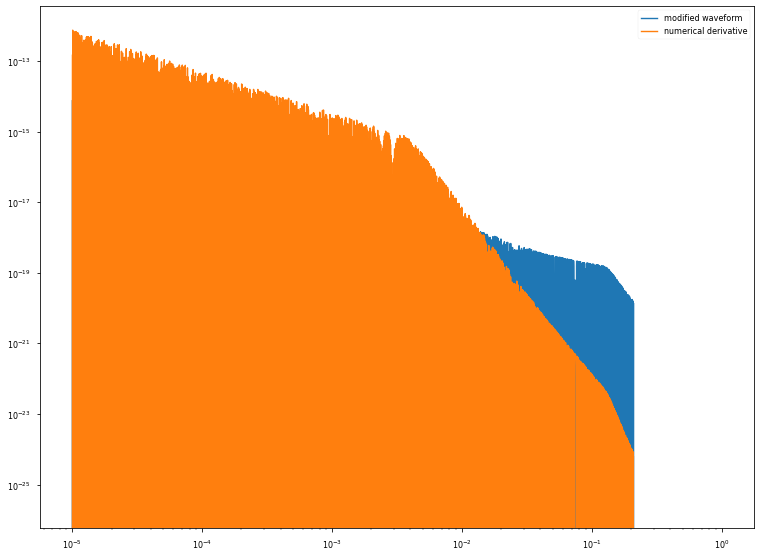

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.loglog(LISA_prop1.fT.value, hp_grav_fd, label='modified waveform')
plt.loglog(LISA_prop1.fT.value, result_grav, label='numerical derivative')
plt.legend()

(0.0, 0.0001)

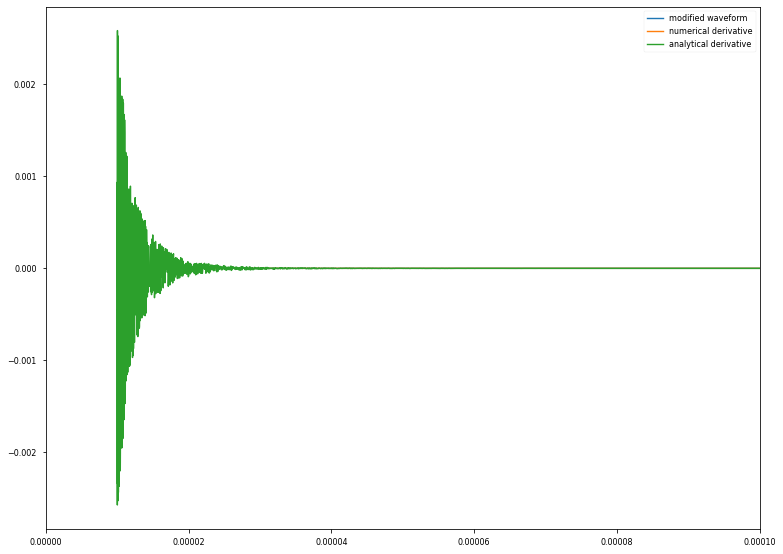

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(LISA_prop1.fT.value, hp_grav_fd, label='modified waveform')
plt.plot(LISA_prop1.fT.value, result_grav, label='numerical derivative')
plt.plot(LISA_prop1.fT.value, ddrho_grav_fd, label='analytical derivative')
plt.legend()
plt.xlim(0,0.0001)

## Let's try Newman's approach to dealing with derivatives of noisy data.

We use `interp1d` and `scipy.misc.derivative` to deal with the numerical derivative term of the Fisher integrand.

In [ ]:
rho0_array = np.linspace(0,1,len(LISA_prop1.fT.value), endpoint=True)

hp_grav_rho0d = return_hp_grav_fd(rho0_array)
hp_drag_rho0d = return_hp_drag_fd(rho0_array)
hp_bondi_rho0d = return_hp_bondi_fd(rho0_array)
hp_colless_rho0d = return_hp_colless_fd(rho0_array)

return_hp_grav_curve = interp1d(rho0_array, hp_grav_rho0d, fill_value='extrapolate')
return_hp_drag_curve = interp1d(rho0_array, hp_drag_rho0d, fill_value='extrapolate')
return_hp_bondi_curve = interp1d(rho0_array, hp_bondi_rho0d, fill_value='extrapolate')
return_hp_colless_curve = interp1d(rho0_array, hp_colless_rho0d, fill_value='extrapolate')

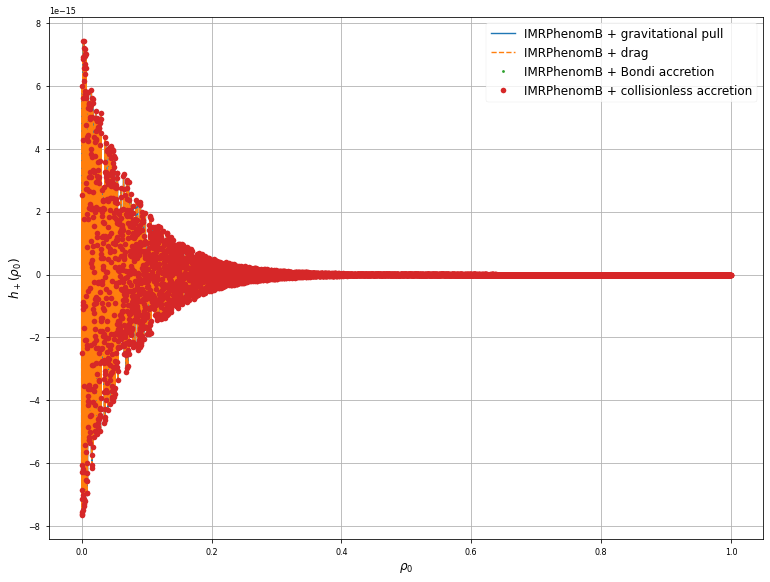

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(rho0_array, hp_grav_rho0d, '-', label=approx+' + gravitational pull')
plt.plot(rho0_array, hp_grav_rho0d, '--', label=approx+' + drag')
plt.plot(rho0_array, hp_grav_rho0d, '.', label=approx+' + Bondi accretion')
plt.plot(rho0_array, hp_grav_rho0d, 'o', label=approx+' + collisionless accretion')
plt.ylabel(r'$h_+(\rho_0)$', fontsize='large')
plt.xlabel(r'$\rho_0$', fontsize='large')
plt.grid()
#plt.xlim(0,0.01)
plt.legend(loc='best', fontsize='large')

In [ ]:
from scipy.misc import derivative

num_ddrho_hp_grav_array = derivative(return_hp_grav_curve, rho0_array, dx=0.01)
num_ddrho_hp_drag_array = derivative(return_hp_drag_curve, rho0_array, dx=0.01)
num_ddrho_hp_bondi_array = derivative(return_hp_bondi_curve, rho0_array, dx=0.01)
num_ddrho_hp_colless_array = derivative(return_hp_colless_curve, rho0_array, dx=0.01)

(-1e-14, 1e-14)

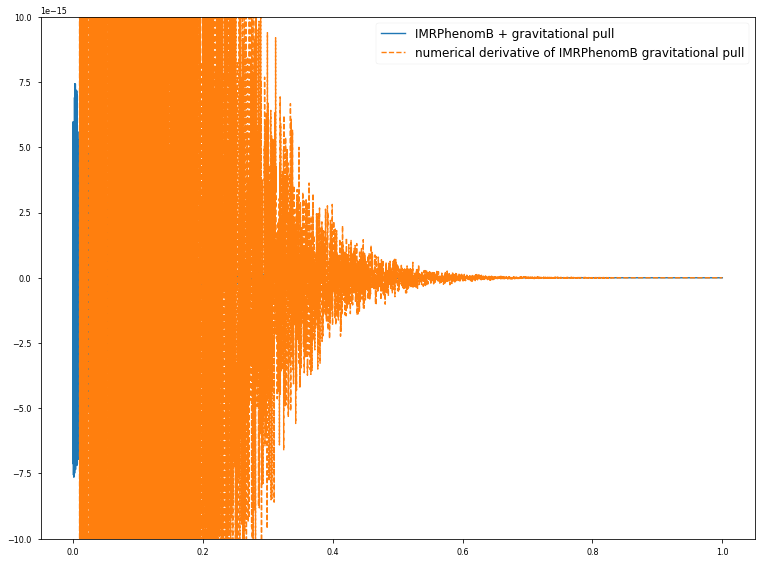

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(rho0_array, hp_grav_rho0d, '-', label=approx+' + gravitational pull')
plt.plot(rho0_array, num_ddrho_hp_grav_array, '--', label='numerical derivative of '+approx+' gravitational pull')
plt.legend(fontsize='large')
plt.ylim(-1e-14,1e-14)

In [ ]:
num_integrand_grav = np.multiply(np.abs(num_ddrho_hp_grav_array), np.abs(num_ddrho_hp_grav_array))/LISA_prop1_Snf
num_integrand_drag = np.multiply(np.abs(num_ddrho_hp_drag_array), np.abs(num_ddrho_hp_drag_array))/LISA_prop1_Snf
num_integrand_bondi = np.multiply(np.abs(num_ddrho_hp_bondi_array), np.abs(num_ddrho_hp_bondi_array))/LISA_prop1_Snf
num_integrand_colless = np.multiply(np.abs(num_ddrho_hp_colless_array), np.abs(num_ddrho_hp_colless_array))/LISA_prop1_Snf

num_Fisher_rho0rho0_grav = np.sum(num_integrand_grav)
num_Fisher_rho0rho0_drag = np.sum(num_integrand_drag)
num_Fisher_rho0rho0_bondi = np.sum(num_integrand_bondi)
num_Fisher_rho0rho0_colless = np.sum(num_integrand_colless)

print(r'$\Gamma_{\rho_0 \rho_0}$ for gravitational pull:', num_Fisher_rho0rho0_grav) # sigma_grav = 10^-4
print(r'$\Gamma_{\rho_0 \rho_0}$ for hydrodynamic drag:', num_Fisher_rho0rho0_drag) # sigma_drag = 10^-19
print(r'$\Gamma_{\rho_0 \rho_0}$ for Bondi accretion:', num_Fisher_rho0rho0_bondi)
print(r'$\Gamma_{\rho_0 \rho_0}$ for collisionless accretion:', num_Fisher_rho0rho0_colless) # sigma_colless = 10^-10

_QUESTION:_ How do we extract the parameters from a stationary phase approximation vacuum waveform?

Apparently, Cardoso and Maselli used Ajith's semi-analytical SPA waveform (eq. 1 in Ajith et. al 2011). I don't think using PyCBC to access IMRPhenom models can be helpful in reproducing their work.

_Correspondence from Maselli:_ "... the [derivative] equation was carried out analytically, but only on the phase. The amplitude is taken as a constant factor which fix
the SNR.
The letter of Ajith should be exactly the PhenomB. I don't know if in PyCBC they have implemented some extra
modifications."

# Replotting results from Mathematica

In [ ]:
#preliminaries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

%matplotlib inline

plt.style.use('tableau-colorblind10')

In [ ]:
pip install --upgrade matplotlib

In [ ]:
# Match the masses used here with that of the SNR calculations, i.e. m_1 = 10^2 to 10^6

sigma_rho0_pull = np.array([0.0628874, 0.00548479, 0.000910462, 0.000177865, 0.000146644], dtype=float)
sigma_rho0_drag = np.array([0.00000000000504704, 0.0000000000000097669, 2.91398e-17, 1.06307e-19, 1.3027e-21], dtype=float)
sigma_rho0_colless = np.array([0.000000776716, 0.0000000445914, 0.00000000419096, 0.000000000475143, 0.000000000195779], dtype=float)

logm1_array = np.arange(2.0,7.0)

In [ ]:
# Create a polynomial fit

from numpy.polynomial import Polynomial

linfit_pull, pull_cov = np.polyfit(logm1_array, np.log10(sigma_rho0_pull), deg=1, cov=True)
linfit_drag, drag_cov = np.polyfit(logm1_array, np.log10(sigma_rho0_drag), deg=1, cov=True)
linfit_colless, colless_cov = np.polyfit(logm1_array, np.log10(sigma_rho0_colless), deg=1, cov=True)

pull_poly = np.poly1d(linfit_pull)
drag_poly = np.poly1d(linfit_drag)
colless_poly = np.poly1d(linfit_colless)

pull_results = linregress(logm1_array, np.log10(sigma_rho0_pull))
drag_results = linregress(logm1_array, np.log10(sigma_rho0_drag))
colless_results = linregress(logm1_array, np.log10(sigma_rho0_colless))

Fit:

$ y = ax + b$


$ \log \sigma_{\rho_0} = a \log m_1 + b$


Covariance matrix:

$\begin{pmatrix} 
\sigma_a^2 & \sigma_{ab}^2 \\
\sigma_{ba}^2 & \sigma_b^2
\end{pmatrix}$

where $a$ and $b$ are the slope and y-intercept, respectively.

In [ ]:
pull_std = np.sqrt(np.diag(pull_cov))
drag_std = np.sqrt(np.diag(drag_cov))
colless_std = np.sqrt(np.diag(colless_cov))

print(pull_cov)
print(drag_cov)
print(colless_cov)

print(pull_std, pull_results.stderr, pull_results.intercept_stderr)
print(drag_std, drag_results.stderr, drag_results.intercept_stderr)
print(colless_std, colless_results.stderr, colless_results.intercept_stderr)

In [ ]:
print(pull_poly, pull_results.slope, pull_results.intercept)
print(drag_poly, drag_results.slope, drag_results.intercept)
print(colless_poly, colless_results.slope, colless_results.intercept)

 
-0.6754 x - 0.1159 -0.6753668190202553 -0.11586467127729261
 
-2.414 x - 6.684 -2.413957954583299 -6.684430915635277
 
-0.9169 x - 4.506 -0.9169419063569754 -4.506148911292264


In [ ]:
import h5py

snr_drag_file = "SNRdragtimenew.h5"
snr_pull_file = "SNRpulltimenew.h5"
snr_colless_file = "SNRcollesstimenew.h5"


with h5py.File(snr_pull_file, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key_pull = list(f.keys())[0]

    # Get the data
    data_snrpull = list(f[a_group_key_pull])

with h5py.File(snr_drag_file, "r") as g:
    # List all groups
    print("Keys: %s" % g.keys())
    a_group_key_drag = list(g.keys())[0]

    # Get the data
    data_snrdrag = list(g[a_group_key_drag])

with h5py.File(snr_colless_file, "r") as h:
    # List all groups
    print("Keys: %s" % h.keys())
    a_group_key_colless = list(h.keys())[0]

    # Get the data
    data_snrcolless = list(h[a_group_key_colless])


Keys: <KeysViewHDF5 ['Dataset1']>
Keys: <KeysViewHDF5 ['Dataset1']>
Keys: <KeysViewHDF5 ['Dataset1']>


In [ ]:
months = np.array(data_snrpull[0])
snr_threshold = np.empty(len(months))

for i in range(len(months)):
  snr_threshold[i] = 10

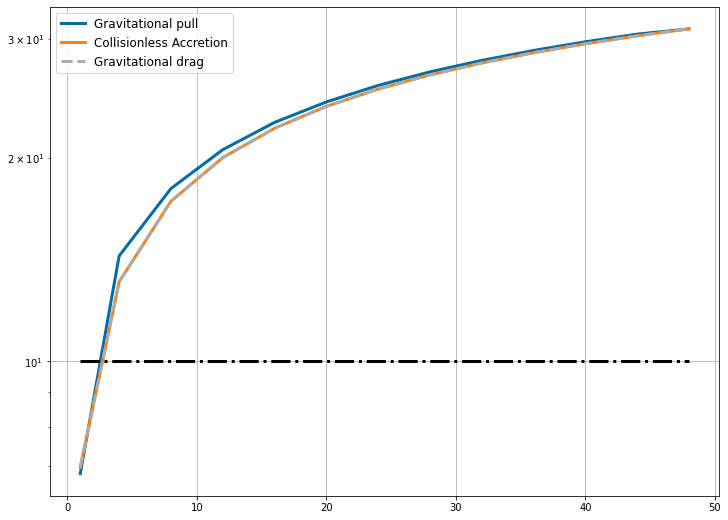

In [ ]:
plt.figure(0, figsize=[12.0, 9.0])

plt.plot(data_snrpull[0], data_snrpull[4], linewidth=3, label='Gravitational pull')
plt.plot(data_snrcolless[0], data_snrcolless[3], linewidth=3, label='Collisionless Accretion')
plt.plot(data_snrdrag[0], data_snrdrag[3], '--', linewidth=3, label='Gravitational drag')
plt.plot(months, snr_threshold, '-.', color='black', linewidth=3)
plt.legend(loc='best', fontsize='large')
plt.yscale('log')
plt.grid()

In [ ]:
print(snr_threshold)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


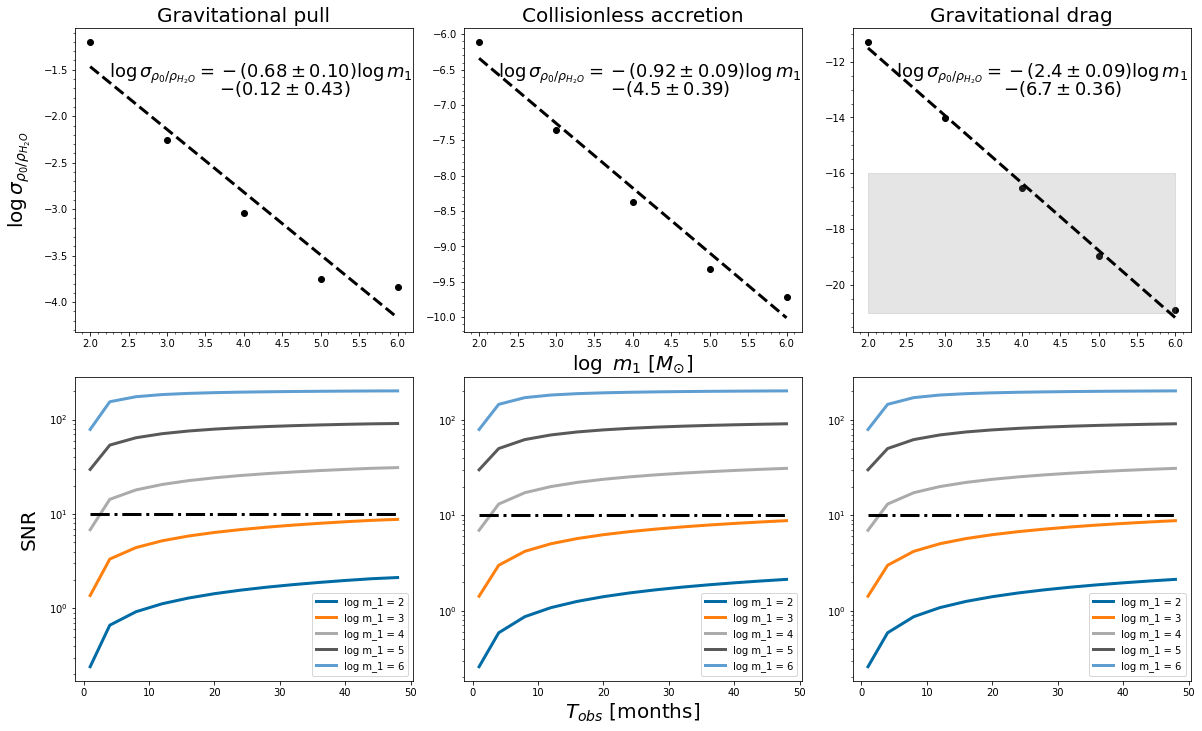

In [ ]:
fig = plt.figure(1, figsize=[20.0, 12.0])
gs = fig.add_gridspec(2,3, hspace=0.15, wspace=0.15)
axs = gs.subplots(sharex='row')


#fig.suptitle('Uncertainties in the density of surrounding medium')
axs[0,0].scatter(logm1_array, np.log10(sigma_rho0_pull), marker='o', color='black',label='Gravitational pull')
axs[0,0].plot(logm1_array, pull_poly(logm1_array), 'k--', label='Linear fit -- pull', linewidth=3)
#axs[0,0].fill_between(logm1_array, y1=-1, y2=-4.7, alpha=0.2, color='blue')
axs[0,0].text(0.55, 0.85, r'$\log \sigma_{\rho_0/\rho_{H_2O}} = -(0.68 \pm 0.10) \log m_1$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,0].transAxes)
axs[0,0].text(0.62, 0.8, r'$ -(0.12 \pm 0.43)$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,0].transAxes)
axs[0,0].set_title('Gravitational pull', fontsize=20)
axs[0,0].minorticks_on()

axs[0,1].scatter(logm1_array, np.log10(sigma_rho0_colless), marker='o', c='black',label='Collisionless accretion')
axs[0,1].plot(logm1_array, colless_poly(logm1_array), 'k--', label='Linear fit -- accretion', linewidth=3)
#axs[0,1].fill_between(logm1_array, y1=-6, y2=-10, alpha=0.2, color='blue')
axs[0,1].text(0.55, 0.85, r'$\log \sigma_{\rho_0/\rho_{H_2O}} = -(0.92 \pm 0.09) \log m_1$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,1].transAxes)
axs[0,1].text(0.61, 0.8, r'$ -(4.5 \pm 0.39)$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,1].transAxes)
axs[0,1].set_title('Collisionless accretion', fontsize=20)
axs[0,1].minorticks_on()

axs[0,2].scatter(logm1_array, np.log10(sigma_rho0_drag), marker='o', c='black', label='Gravitational drag')
axs[0,2].plot(logm1_array, drag_poly(logm1_array), 'k--', label='Linear fit -- drag', linewidth=3)
#axs[0,2].fill_between(logm1_array, y1=-11, y2=-16, alpha=0.2, color='blue')
axs[0,2].fill_between(logm1_array, y1=-16, y2=-21, alpha=0.2, color='gray')
axs[0,2].text(0.56, 0.85, r'$\log \sigma_{\rho_0/\rho_{H_2O}} = -(2.4 \pm 0.09) \log m_1$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,2].transAxes)
axs[0,2].text(0.62, 0.8, r'$ -(6.7 \pm 0.36)$', fontsize=18, horizontalalignment='center',
     verticalalignment='center', transform = axs[0,2].transAxes)
axs[0,2].set_title('Gravitational drag', fontsize=20)
axs[0,2].minorticks_on()

for i in range(2,7):
  axs[1,0].plot(data_snrpull[0], data_snrpull[i], linewidth=3, label='log m_1 = ' + str(i))
#axs[1,0].set_title('Gravitational pull')
axs[1,0].plot(months, snr_threshold, '-.', color='black', linewidth=3)

for k in range(1,6):
  axs[1,1].plot(data_snrcolless[0], data_snrcolless[k], linewidth=3, label='log m_1 = ' + str(k+1))
#axs[1,1].set_title('Collisionless accretion')
axs[1,1].plot(months, snr_threshold, '-.', color='black', linewidth=3)


for j in range(1,6):
  axs[1,2].plot(data_snrdrag[0], data_snrdrag[j], linewidth=3, label='log m_1 = ' + str(j+1))
#axs[1,2].set_title('Gravitational drag')
axs[1,2].plot(months, snr_threshold, '-.', color='black', linewidth=3)


for i in range(3):
  axs[1,i].legend(loc='best', fontsize=10)
#ax2.legend(fontsize='large')
#ax3.legend(fontsize='large')
#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

axs[0,1].set_xlabel(r'$\log ~m_1 ~[M_{\odot}]$', fontsize=20)
axs[1,1].set_xlabel(r'$T_{obs}$ [months]', fontsize=20)

#for i in range(3):
#  axs[i,1].yaxis.set_label_position("right")
#  axs[i,1].yaxis.tick_right()

axs[0,0].set_ylabel(r'$\log \sigma_{\rho_0/\rho_{H_2O}}$', fontsize=20, labelpad=10)
axs[1,0].set_ylabel(r'SNR', fontsize=20, labelpad=10)

#for ax in axs.flat:
#  ax.label_outer()
#fig.supylabel(r'$\log \sigma_{\rho_0}$')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[1,2].set_yscale('log')
#plt.savefig('logsigma_rho0vslogm1.jpg')
plt.savefig('SPP2021_mainresults.png')

# Trying PCA on Fisher results

In [ ]:
#preliminaries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import h5py

%matplotlib inline

plt.style.use('tableau-colorblind10')

In [ ]:
Fisher_pull_q10e1_file = "IMRIFisherlogm12.h5"
Fisher_pull_q10e2_file = "IMRIFisherlogm13.h5"
Fisher_pull_q10e3_file = "IMRIFisherlogm14.h5"
Fisher_pull_q10e4_file = "EMRIFisherpulllogm15.h5"
Fisher_pull_q10e5_file = "EMRIFisherpulllogm16.h5"
Fisher_pull_q10e6_file = "EMRIFisherpulllogm17.h5"
Fisher_pull_q10e7_file = "EMRIFisherpulllogm18.h5"
Fisher_pull_q10e8_file = "EMRIFisherpulllogm19.h5"
Fisher_drag_q10e1_file = "IMRIFisherdraglogm12.h5"
Fisher_drag_q10e2_file = "IMRIFisherdraglogm13.h5"
Fisher_drag_q10e3_file = "IMRIFisherdraglogm14.h5"
Fisher_drag_q10e4_file = "EMRIFisherdraglogm15.h5"
Fisher_drag_q10e5_file = "EMRIFisherdraglogm16.h5"
Fisher_drag_q10e6_file = "EMRIFisherdraglogm17.h5"
Fisher_drag_q10e7_file = "EMRIFisherdraglogm18.h5"
Fisher_drag_q10e8_file = "EMRIFisherdraglogm19.h5"
Fisher_colless_q10e1_file = "IMRIFishercollesslogm12.h5"
Fisher_colless_q10e2_file = "IMRIFishercollesslogm13.h5"
Fisher_colless_q10e3_file = "IMRIFishercollesslogm14.h5"
Fisher_colless_q10e4_file = "EMRIFishercollesslogm15.h5"
Fisher_colless_q10e5_file = "EMRIFishercollesslogm16.h5"
Fisher_colless_q10e6_file = "EMRIFishercollesslogm17.h5"
Fisher_colless_q10e7_file = "EMRIFishercollesslogm18.h5"
Fisher_colless_q10e8_file = "EMRIFishercollesslogm19.h5"


with h5py.File(Fisher_pull_q10e1_file, "r") as a:
    # List all groups
    print("Keys: %s" % a.keys())
    a_group_key_pull_q10e1 = list(a.keys())[0]

    # Get the data
    Fisher_pull_q10e1_data = list(a[a_group_key_pull_q10e1])

with h5py.File(Fisher_pull_q10e2_file, "r") as b:
    # List all groups
    print("Keys: %s" % b.keys())
    a_group_key_pull_q10e2 = list(b.keys())[0]

    # Get the data
    Fisher_pull_q10e2_data = list(b[a_group_key_pull_q10e2])

with h5py.File(Fisher_pull_q10e3_file, "r") as c:
    # List all groups
    print("Keys: %s" % c.keys())
    a_group_key_pull_q10e3 = list(c.keys())[0]

    # Get the data
    Fisher_pull_q10e3_data = list(c[a_group_key_pull_q10e3])

with h5py.File(Fisher_pull_q10e4_file, "r") as d:
    # List all groups
    print("Keys: %s" % d.keys())
    a_group_key_pull_q10e4 = list(d.keys())[0]

    # Get the data
    Fisher_pull_q10e4_data = list(d[a_group_key_pull_q10e4])

with h5py.File(Fisher_pull_q10e5_file, "r") as e:
    # List all groups
    print("Keys: %s" % e.keys())
    a_group_key_pull_q10e5 = list(e.keys())[0]

    # Get the data
    Fisher_pull_q10e5_data = list(e[a_group_key_pull_q10e5])

with h5py.File(Fisher_pull_q10e6_file, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key_pull_q10e6 = list(f.keys())[0]

    # Get the data
    Fisher_pull_q10e6_data = list(f[a_group_key_pull_q10e6])

with h5py.File(Fisher_pull_q10e7_file, "r") as g:
    # List all groups
    print("Keys: %s" % g.keys())
    a_group_key_pull_q10e7 = list(g.keys())[0]

    # Get the data
    Fisher_pull_q10e7_data = list(g[a_group_key_pull_q10e7])

with h5py.File(Fisher_pull_q10e8_file, "r") as h:
    # List all groups
    print("Keys: %s" % h.keys())
    a_group_key_pull_q10e8 = list(h.keys())[0]

    # Get the data
    Fisher_pull_q10e8_data = list(h[a_group_key_pull_q10e8])

with h5py.File(Fisher_drag_q10e1_file, "r") as i:
    # List all groups
    print("Keys: %s" % i.keys())
    a_group_key_drag_q10e1 = list(i.keys())[0]

    # Get the data
    Fisher_drag_q10e1_data = list(i[a_group_key_drag_q10e1])

with h5py.File(Fisher_drag_q10e2_file, "r") as j:
    # List all groups
    print("Keys: %s" % j.keys())
    a_group_key_drag_q10e2 = list(j.keys())[0]

    # Get the data
    Fisher_drag_q10e2_data = list(j[a_group_key_drag_q10e2])

with h5py.File(Fisher_drag_q10e3_file, "r") as k:
    # List all groups
    print("Keys: %s" % k.keys())
    a_group_key_drag_q10e3 = list(k.keys())[0]

    # Get the data
    Fisher_drag_q10e3_data = list(k[a_group_key_drag_q10e3])

with h5py.File(Fisher_drag_q10e4_file, "r") as l:
    # List all groups
    print("Keys: %s" % l.keys())
    a_group_key_drag_q10e4 = list(l.keys())[0]

    # Get the data
    Fisher_drag_q10e4_data = list(l[a_group_key_drag_q10e4])

with h5py.File(Fisher_drag_q10e5_file, "r") as m:
    # List all groups
    print("Keys: %s" % m.keys())
    a_group_key_drag_q10e5 = list(m.keys())[0]

    # Get the data
    Fisher_drag_q10e5_data = list(m[a_group_key_drag_q10e5])

with h5py.File(Fisher_drag_q10e6_file, "r") as n:
    # List all groups
    print("Keys: %s" % n.keys())
    a_group_key_drag_q10e6 = list(n.keys())[0]

    # Get the data
    Fisher_drag_q10e6_data = list(n[a_group_key_drag_q10e6])

with h5py.File(Fisher_drag_q10e7_file, "r") as o:
    # List all groups
    print("Keys: %s" % o.keys())
    a_group_key_drag_q10e7 = list(o.keys())[0]

    # Get the data
    Fisher_drag_q10e7_data = list(o[a_group_key_drag_q10e7])

with h5py.File(Fisher_drag_q10e8_file, "r") as p:
    # List all groups
    print("Keys: %s" % p.keys())
    a_group_key_drag_q10e8 = list(p.keys())[0]

    # Get the data
    Fisher_drag_q10e8_data = list(p[a_group_key_drag_q10e8])

with h5py.File(Fisher_colless_q10e1_file, "r") as q:
    # List all groups
    print("Keys: %s" % q.keys())
    a_group_key_colless_q10e1 = list(q.keys())[0]

    # Get the data
    Fisher_colless_q10e1_data = list(q[a_group_key_colless_q10e1])

with h5py.File(Fisher_colless_q10e2_file, "r") as r:
    # List all groups
    print("Keys: %s" % r.keys())
    a_group_key_colless_q10e2 = list(r.keys())[0]

    # Get the data
    Fisher_colless_q10e2_data = list(r[a_group_key_colless_q10e2])

with h5py.File(Fisher_colless_q10e3_file, "r") as s:
    # List all groups
    print("Keys: %s" % s.keys())
    a_group_key_colless_q10e3 = list(s.keys())[0]

    # Get the data
    Fisher_colless_q10e3_data = list(s[a_group_key_colless_q10e3])

with h5py.File(Fisher_colless_q10e4_file, "r") as t:
    # List all groups
    print("Keys: %s" % t.keys())
    a_group_key_colless_q10e4 = list(t.keys())[0]

    # Get the data
    Fisher_colless_q10e4_data = list(t[a_group_key_colless_q10e4])

with h5py.File(Fisher_colless_q10e5_file, "r") as u:
    # List all groups
    print("Keys: %s" % u.keys())
    a_group_key_colless_q10e5 = list(u.keys())[0]

    # Get the data
    Fisher_colless_q10e5_data = list(u[a_group_key_colless_q10e5])

with h5py.File(Fisher_colless_q10e6_file, "r") as v:
    # List all groups
    print("Keys: %s" % v.keys())
    a_group_key_colless_q10e6 = list(v.keys())[0]

    # Get the data
    Fisher_colless_q10e6_data = list(v[a_group_key_colless_q10e6])

with h5py.File(Fisher_colless_q10e7_file, "r") as w:
    # List all groups
    print("Keys: %s" % w.keys())
    a_group_key_colless_q10e7 = list(w.keys())[0]

    # Get the data
    Fisher_colless_q10e7_data = list(w[a_group_key_colless_q10e7])

with h5py.File(Fisher_colless_q10e8_file, "r") as x:
    # List all groups
    print("Keys: %s" % x.keys())
    a_group_key_colless_q10e8 = list(x.keys())[0]

    # Get the data
    Fisher_colless_q10e8_data = list(x[a_group_key_colless_q10e8])

In [ ]:
# Combine the covariance matrices onto one array

print(np.shape(np.concatenate((Fisher_pull_q10e1_data[1], Fisher_pull_q10e2_data[1], Fisher_pull_q10e3_data[1], Fisher_pull_q10e4_data[1], Fisher_pull_q10e5_data[1], Fisher_pull_q10e6_data[1], Fisher_pull_q10e7_data[1], Fisher_pull_q10e8_data[1]))))

(48, 6)


In [ ]:
print(np.allclose(np.linalg.inv(np.linalg.eigh(Fisher_pull_q10e4_data[0])[1]), np.linalg.eigh(Fisher_pull_q10e4_data[1])[1]))
#print(np.linalg.eigh(Fisher_pull_q10e4_data[0]))
print(np.linalg.eigh(Fisher_pull_q10e4_data[0])[0])

False
[-1.89031283e+14  3.19783080e-02  2.80908300e+02  8.84005739e+13
  3.91437134e+15  6.01440322e+33]


In [ ]:
#print(np.linalg.eigh(Fisher_pull_q10e4_data[1])[0])

D = np.array([[np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][0],0,0,0,0,0], [0, np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][1], 0,0,0,0], [0,0, np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][2],0,0,0], [0,0,0, np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][3], 0,0], [0,0,0,0,np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][4],0], [0,0,0,0,0,np.linalg.eigh(Fisher_pull_q10e4_data[1])[0][5]]])
#print(D)

lhs = np.matmul(Fisher_pull_q10e4_data[1], np.linalg.eigh(Fisher_pull_q10e4_data[1])[1])
rhs = np.matmul(np.linalg.eigh(Fisher_pull_q10e4_data[1])[1], D)

print(lhs - rhs)

[[-6.11815905e-12  4.49734424e-24  5.01973519e-13 -9.31733678e-16
  -1.28215377e-17  8.88178420e-16]
 [ 7.90937825e-13  1.28482708e-22 -8.65618951e-11  8.21470094e-06
  -1.12232069e-09 -1.93386694e-04]
 [-7.33695376e-12 -1.11509116e-21 -3.75741316e-10 -1.47882087e-05
   6.93716834e-09 -3.66210938e-04]
 [ 2.75978870e-18  1.78676995e-28  3.94735460e-15 -1.92612255e-10
   1.55431223e-15  4.65661287e-10]
 [ 3.42423188e-22  5.57526626e-32  1.86330317e-20  6.92284354e-16
  -3.25260652e-19  2.13162821e-14]
 [ 1.60283944e-33  2.93311337e-43  3.12260576e-31 -8.37409186e-27
  -8.87468518e-31  1.03397577e-25]]


In [ ]:
print(np.linalg.eigh(Fisher_pull_q10e4_data[1])[1])

[[-9.96651085e-01  7.32619566e-13  8.17717283e-02  9.57460184e-07
  -2.10049053e-06  4.33378611e-12]
 [-9.63998736e-08 -1.56317859e-17  1.05367373e-05 -9.99999994e-01
   1.06681031e-04 -2.85311996e-10]
 [ 5.18284262e-14  2.75056869e-22 -3.90473213e-11 -9.95900049e-11
  -3.60796831e-06 -1.00000000e+00]
 [ 1.66143652e-07  2.34264805e-16 -2.36610032e-05 -1.06681280e-04
  -9.99999994e-01  3.60796830e-06]
 [ 8.17717284e-02 -2.02377758e-11  9.96651084e-01  1.04910536e-05
  -2.35692980e-05  4.61239183e-11]
 [ 2.38504399e-12  1.00000000e+00  2.01100936e-11  1.96007342e-16
  -2.41184836e-16  3.60102920e-22]]
